In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging


import gstools as gs

## Функции

In [3]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

(80,) (80,)


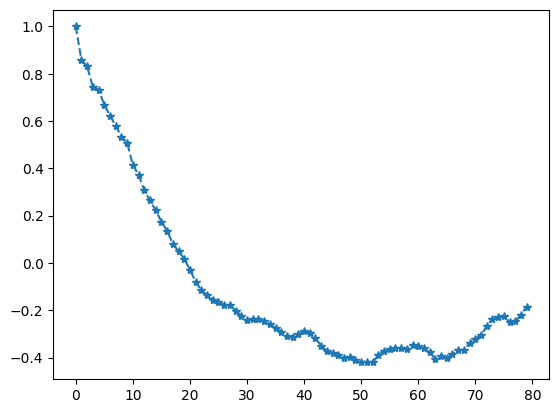

Проверка не нормированной корр. функции 15.032831320595543 0.9999999999999998


In [4]:
"""
Создание матрицы расстояний и произведение значений
"""
def get_corr(points, values, max_h, start=0, step=1, normal=False):
    def matrix_distance_and_value(points, values):

        l = len(points)
        D = np.zeros((l, l))
        V = np.zeros((l, l))
        M = np.mean(values)
        var = np.var(values)

        for i in range(l):
            for j in range(i, l):
                distance = np.linalg.norm(points[i] - points[j])
                D[i, j] = distance

                if normal:
                    V[i, j] = (values[i]-M)*(values[j]-M) / var
                else:
                    V[i, j] = (values[i]-M)*(values[j]-M)
        return D, V
    
    
    corr_list, h_list = [], []
    D, V = matrix_distance_and_value(points, values)
    
    for h in range(start, max_h, step):
        """
        Суммарная корреляция в диапазоне (h-step, h-step]
        """
        sum_V = np.sum(np.where((D <= h) & (D > h-step), V, 0))

        """
        количество элементов в диапазоне (h-step, h-step]
        """
        D_list = D.reshape(-1)
        num_V = np.where((D_list <= h) & (D_list > h-step))[0].shape[0]

        if h == 0:
            """
            Частный случай корр. в точки 0
            """
            num_V = len(points)

        h_list.append(h)
        corr_list.append(sum_V/num_V)
    
    return np.array(h_list), np.array(corr_list)


# Пример
borehole = "тсз147"
df = pd.read_excel("data" + "\\" + borehole +".xlsx")
df = df.loc[:, ["E", "soil_kind", "h"]]
df_filter = get_filter_df(df, "E")
x, y = get_corr(df_filter["h"].to_numpy()*10, df_filter['E'].to_numpy(), 80, normal=True)
print(x.shape, y.shape)
plt.plot(x, y, "--*")
plt.show()
print("Проверка не нормированной корр. функции", np.var(df_filter['E'].to_numpy()), y[0])

In [5]:
class MyCovModel(gs.CovModel):
    """
    Класс для использования своей ковариационной функции в кригинге из библиотеки gs
    """
    def __init__(self, dim=3, var=1.0, len_scale=1.0, nugget=0.0, anis=1.0, 
                 angles=0.0, 
                 **kwargs
                ):
        super().__init__(dim)
        self.var = var
        self.len_scale = len_scale
        self.nugget = nugget
        self.anis = anis
        self.angles = angles

        self.Dl = kwargs.get('Dl', .25)
        self.Df = kwargs.get('Df', .02)
        self.w = kwargs.get('w', 4)

    def cor(self, h):
        # Здесь определяем ковариационную функцию
        return self.Dl * np.exp(-np.abs(h) / self.len_scale) + self.nugget
        #return np.exp(-np.abs(h[0]) / self.len_scale) + np.exp(-np.abs(h[1]) / self.w) + self.nugget
        #return self.Dl * np.exp(-np.abs(h)/self.len_scale) + self.Df * np.exp(-np.abs(h)/self.len_scale) * np.cos(h/self.w)
        #return self.Dl * np.exp(-np.abs(h)/self.len_scale) + self.Df * np.exp(-np.abs(h)/self.len_scale) * np.cos(h/self.w) + self.nugget


def my_cor_func(h, dl, df, al, af, w):
    """
    Возвращает нашу ковар. функцию, необходимо для подбора параметров
    """
    #df=0.1
    #return abs(df)*np.exp(-abs(h)/af)*np.cos(h/w)
    return abs(dl)*np.exp(-abs(h)/af) + abs(df)*np.exp(-abs(h)/af)*np.cos(h/w)

In [6]:
def predict_value(corr_matrix, known_values, corr_with_unknown):
    """
    Определение значения в неизвестной точке на основе корреляционной матрицы и значений в известных точках.
    Parameters:
        corr_matrix (numpy.ndarray): Корреляционная матрица (n x n) для известных точек.
        known_values (numpy.ndarray): Вектор значений в известных точках (n).
        corr_with_unknown (numpy.ndarray): Вектор корреляций между известными точками и неизвестной точкой (n).
    Returns:
        float: Предсказанное значение в неизвестной точке.
    """
    lambdas = np.linalg.solve(corr_matrix, corr_with_unknown) # Решаем систему R * λ = r для нахождения вектора весов λ 
    return np.dot(lambdas, known_values) # Вычисляем значение в неизвестной точке как линейную комбинацию известных значений

# Пример данных
corr_matrix = np.array([
    [1.0, 0.8, 0.5],
    [0.8, 1.0, 0.3],
    [0.5, 0.3, 1.0]
])
known_values = np.array([3.0, 2.5, 4.0])  # Значения в известных точках
corr_with_unknown = np.array([0.7, 0.6, 0.4])  # Корреляция между известными точками и неизвестной

# Предсказание значения в неизвестной точке
predicted_value = predict_value(corr_matrix, known_values, corr_with_unknown)
print(f"Предсказанное значение в неизвестной точке: {predicted_value}")

Предсказанное значение в неизвестной точке: 2.3249999999999997


In [7]:
"""
Кросс-валидация для кригинга
"""
def cross_valid_for_RK(ml_model, variogram_model, blocks_X, blocks_y, k):
    scores = [] # Инициализация списка для хранения оценок
    
    for i in range(k):
        # Создание обучающей и тестовой выборок
        X_train = np.concatenate([blocks_X[j] for j in range(k) if j != i])
        y_train = np.concatenate([blocks_y[j] for j in range(k) if j != i])
        X_test = blocks_X[i]
        y_test = blocks_y[i]
        # Обучение модели на обучающей выборке
        RK = RegressionKriging(regression_model=ml_model, n_closest_points=10, variogram_model=variogram_model)
        RK.fit(X_train, X_train, y_train)
        
        y_pred = RK.predict(X_test, X_test)

        score = r2_score(y_test, y_pred)
        #if score < -1: score = -1
        scores.append(score)
    return scores

## Исходные данные

In [8]:
df_house_3 = pd.read_excel("data/house_3_local.xlsx")
b_train, b_test = train_test_split(df_house_3, test_size=0.1, random_state=12345)

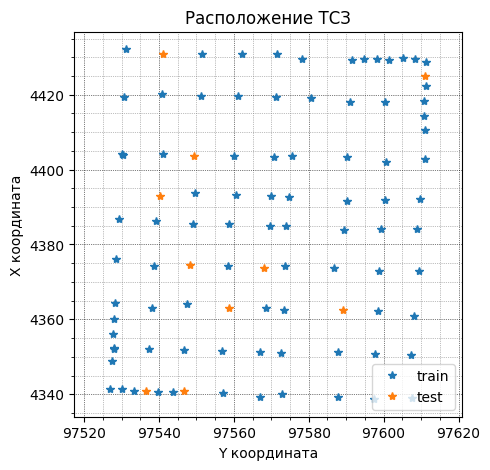

In [9]:
plt.figure(figsize=(5, 5))

plt.plot(b_train["x"], b_train["y"], "*", label="train")
plt.plot(b_test["x"], b_test["y"], "*", label="test")

plt.title('Расположение ТСЗ')
plt.xlabel('Y координата')
plt.ylabel('X координата')
# Сохранение пропорций X Y
plt.axis('equal')
# Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# Включаем дополнительные деления на осях
plt.minorticks_on()
plt.legend()
plt.show()

## Определение значений корр. и запись в матрицу всех скважин

In [10]:
clay_border = [73.5, 65]
max_borehole = df_house_3["тсз"].max()

scale_x = 10
corr_size = 15 * scale_x
matrix_corr_boreholes = np.zeros((max_borehole+1, corr_size))

show_plot_flag = False
corr_normal = False
model = 'exponential'

for i in df_house_3["тсз"]:
    borehole = f"тсз{i}"
    z_borehole = df_house_3.query('тсз == @i')["z"].iloc[0] # абсолютная отметка устья скважины
    
    df = pd.read_excel(f"data/{borehole}.xlsx")
    df["z_sample"] = z_borehole - df["h"]
    df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]')
    df = df.loc[:, ["E", "soil_kind", "h"]]
    df_filter = get_filter_df(df, "E")
    
    x = df_filter["h"].to_numpy() * scale_x
    y = np.array([0]*x.shape[0])
    E = df_filter["E"].to_numpy()

    # построение корр функции
    x_plot, y_plot = get_corr(x, E, corr_size, normal=corr_normal)
    
    """
    Запись коэф. корр. в матрицу
    """
    matrix_corr_boreholes[i, :] = y_plot
    
    if show_plot_flag:
            """
            Визуализация
            """
            plt.figure(figsize=(3, 6))
            plt.title(f'Скважина {borehole}')
            plt.xlabel('корреляция')
            plt.ylabel('расстояние между точками [м]')
            plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
            plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            plt.minorticks_on()
    
            plt.plot(y_plot, x_plot/scale_x, "--*", label="корреляция")
            plt.plot([0, 0], [0, corr_size/scale_x], "-", label="ось в точке 0")
    
            if corr_normal:
                plt.plot([1, 1], [0, corr_size/scale_x], "-", label="ось в точке 1")
            
            plt.legend()
            plt.show()

In [11]:
boreholes = np.where(np.sum(matrix_corr_boreholes, axis=1)!=0)[0]

df_corr_from_boreholes = pd.DataFrame(matrix_corr_boreholes[boreholes, :], columns=range(corr_size))
df_corr_from_boreholes["тсз"] = boreholes
#df_corr_from_boreholes = df_corr_from_boreholes.merge(df_house_3, on="тсз", how="left")

df_corr_from_boreholes = df_corr_from_boreholes.dropna(axis=1, how="all")

In [12]:
df_corr_from_boreholes.to_excel("data/corr_boreholes_house_3.xlsx", index=False)

## Прогноз значения корр.

In [13]:
df_corr_train = df_corr_from_boreholes.merge(b_train, on="тсз", how="right").sample(frac=1, random_state=12345)
df_corr_train

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,тсз,x,y,z
49,10.247269,8.852660,8.048294,7.511361,6.867257,6.261523,6.177383,5.935341,5.756791,5.553541,...,4.344793,0.694179,-5.288925,1.028801,2.335256,NaN,95,97571.595111,4430.768969,76.632
65,16.344680,14.303748,13.123597,12.414159,11.242978,10.684329,10.094943,9.355565,9.189954,8.296139,...,30.926234,40.400732,56.075981,61.792105,92.761038,127.093791,106,97546.779783,4351.822961,76.595
70,17.340875,15.426854,13.709781,12.804940,11.535025,10.998726,9.885376,9.006812,8.548843,8.262152,...,11.056887,16.738139,27.877953,13.446530,11.028960,30.673184,58,97610.682903,4418.395458,76.656
33,7.550015,6.090232,5.725581,4.867410,4.640867,4.243276,3.919551,3.788598,3.640462,3.453763,...,-12.700362,-13.338292,-16.323606,-14.550520,-16.292470,-9.251894,144,97527.477459,4348.822376,76.474
83,18.066196,14.491027,13.095557,12.272769,11.415439,10.789572,9.585801,9.524210,9.859927,8.705659,...,30.841215,33.262265,35.943436,48.796811,57.676582,75.464463,92,97569.990891,4392.973735,76.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,10.598412,9.434309,8.443985,7.621521,6.855031,6.499409,6.352922,6.222582,6.176359,6.003765,...,32.690982,41.855528,47.262235,NaN,NaN,NaN,97,97556.856522,4351.566830,76.481
41,18.274953,15.934575,14.632591,13.413762,12.101557,10.800960,10.036975,8.187044,6.946822,6.386067,...,48.912393,48.741409,51.851801,53.995527,40.444171,29.564455,75,97590.347931,4403.469941,76.490
36,7.498809,7.064491,6.706547,6.472094,6.159489,5.928984,5.772402,5.544928,5.237511,5.083719,...,-7.289689,-7.241893,-7.003393,-7.246607,-8.250019,NaN,127,97529.230818,4386.814511,76.570
1,13.269289,12.469271,11.918825,11.333912,10.963810,10.329044,9.856274,9.433279,9.162497,8.865195,...,-17.155832,-19.244313,-21.468148,-20.624570,-16.148912,-13.046230,55,97609.017249,4384.096561,76.608


In [14]:
df_corr_test = df_corr_from_boreholes.merge(b_test, on="тсз", how="right").sample(frac=1, random_state=12345)
df_corr_test

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,тсз,x,y,z
0,7.559868,7.166916,6.736390,6.510565,6.363338,6.029325,5.622905,5.372046,5.185535,4.878825,...,-11.304172,-11.492839,-11.779922,-12.699919,-12.943774,NaN,119,97540.199829,4392.947651,76.520
7,17.036036,15.281941,13.231203,12.305661,10.826478,8.942685,8.161193,7.843419,6.679885,5.909254,...,37.836524,26.186760,14.307159,8.476944,20.478740,7.669611,90,97568.174514,4373.768368,76.533
3,13.026892,10.542812,9.474937,9.367160,9.062837,8.030106,7.487507,7.630329,7.249505,6.147350,...,21.908849,23.420212,37.107796,15.023847,25.055234,43.793108,108,97548.377775,4374.535688,76.488
9,13.051033,11.945611,11.045698,10.228282,9.210891,8.631748,8.201343,7.791034,7.709839,7.262558,...,-4.541357,-3.196486,-4.154833,1.322628,12.002309,9.314497,114,97536.535137,4340.821720,76.412
6,5.398190,4.800432,4.725291,4.650520,4.422361,4.205559,4.064085,3.839257,3.751153,3.478157,...,0.402962,-4.543848,4.908457,2.235896,NaN,NaN,122,97541.035044,4430.976435,76.659
4,22.595732,19.457267,15.849522,14.276408,15.565877,16.626721,15.759311,14.315714,13.057306,12.427065,...,-23.308889,18.608750,11.630000,-20.437500,-30.594000,-31.600000,71,97589.091303,4362.399573,76.562
1,15.722099,13.880595,11.540884,10.208758,9.491535,9.046436,8.383468,8.012969,7.828118,7.883981,...,56.845880,80.098443,83.715262,31.717358,34.059316,39.283684,135,97611.014355,4424.924263,76.755
8,6.398157,5.267635,4.824346,4.489859,4.279672,3.977333,3.837124,3.732807,3.692545,3.438009,...,1.046823,6.826477,32.069191,44.189526,NaN,NaN,111,97549.300554,4403.506190,76.571
5,17.407611,15.060793,14.412415,13.473348,12.479015,11.837899,10.314027,9.678732,9.255303,8.806960,...,44.470434,39.567745,53.280380,52.899461,83.197989,88.454860,98,97558.706811,4362.919936,76.490
2,11.748937,9.963492,8.992725,8.414457,8.253470,7.888291,7.609196,7.318063,7.002276,6.849438,...,-17.264862,-13.715665,NaN,NaN,NaN,NaN,105,97546.684437,4340.939477,76.384


0.47613856820334244


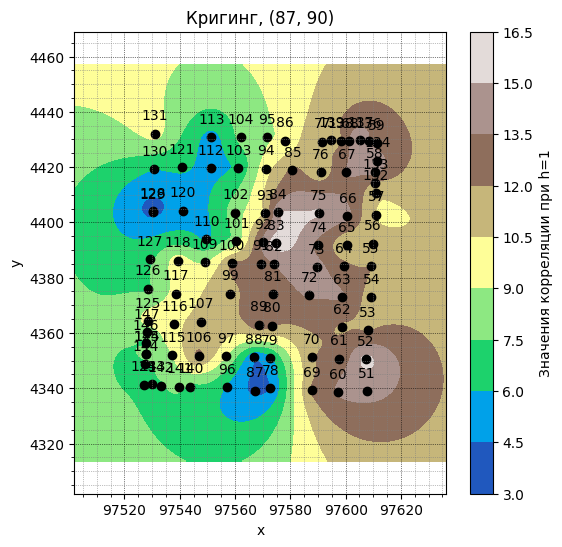

In [15]:
model = 'exponential'
num_corr = 1

x = df_corr_train["x"].to_numpy()
y = df_corr_train["y"].to_numpy()
E = df_corr_train[num_corr].to_numpy()

labels = df_corr_train["тсз"].to_numpy()

UK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                     )

z_predict, variance = UK.execute('points', df_corr_test["x"].to_numpy(), df_corr_test["y"].to_numpy())
print(r2_score(df_corr_test[num_corr], z_predict))

x_new = np.linspace(np.min(x)-25, np.max(x)+25, 200)
y_new = np.linspace(np.min(y)-25, np.max(y)+25, 200)
z_new, variance = UK.execute('grid', x_new, y_new)
    
X, Y = np.meshgrid(x_new, y_new)
    
plt.figure(figsize=(6, 6))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axis('equal')
plt.contourf(X, Y, z_new, cmap='terrain', levels=10)
cbar = plt.colorbar()
cbar.set_label(f'Значения корреляции при h={num_corr}')
for i in range(len(x)):
    plt.scatter(x[i], y[i], color="k")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title(f'Кригинг, {df_corr_train.shape}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Подбор коэф. с помощью кросс валидации

In [16]:
svr_model1 = SVR(C=0.1, gamma="auto", kernel='rbf')
svr_model2 = SVR(C=0.1, gamma="auto", kernel="sigmoid")
#svr_model3 = SVR(C= 10, coef0= np.min(target_test), epsilon= 0.1, gamma= 'scale', kernel= 'sigmoid')
lr_model = LinearRegression(copy_X=True, fit_intercept=False)
br_model = BayesianRidge()
et_model = ExtraTreeRegressor()
tr_model = TweedieRegressor()

models = [svr_model1, svr_model2, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1", "SVR2", "LR", "BR", "ET", "TR"]
dict_models = {}
r2_dict = {}

In [17]:
"""
ML
"""
for i in range(len(models)):
    model = models[i]
    scores = cross_val_score(model, 
                             df_corr_train.loc[:, ["x", "y"]].to_numpy(), 
                             df_corr_train.loc[:, 1].to_numpy(), 
                             cv=10
                            )
    print(f'модель {name_models[i]}:', round(scores.mean(),2))

модель SVR1: -0.33
модель SVR2: -0.34
модель LR: -0.34
модель BR: 0.09
модель ET: -0.52
модель TR: 0.09


In [18]:
variogram_model = 'exponential'
k = 10 # Определение количества разбиений для кросс-валидации
num_corr = 1 # Столбец в матрице значений корр.
blocks_X = np.array_split(df_corr_train.loc[:, ["x", "y"]].to_numpy(), k)
blocks_y = np.array_split(df_corr_train.loc[:, num_corr].to_numpy(), k)

for i in range(len(models)):
    
    num_corr = 1 # Столбец в матрице значений корр.
    x_train = df_corr_train.loc[:, ["x", "y"]].to_numpy()
    p_train = df_corr_train.loc[:, ["x", "y"]].to_numpy()
    target_train = df_corr_train.loc[:, num_corr].to_numpy()
    
    x_test = df_corr_test.loc[:, ["x", "y"]].to_numpy()
    p_test = df_corr_test.loc[:, ["x", "y"]].to_numpy()
    target_test = df_corr_test.loc[:, num_corr].to_numpy()
    #blocks_X = np.array_split(df_corr_train.loc[:, ["x", "y"]].to_numpy(), k)
    #blocks_y = np.array_split(df_corr_train.loc[:, num_corr].to_numpy(), k)
    
    m = models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])
    
    try:
      
        
        scores = cross_valid_for_RK(m, variogram_model, blocks_X, blocks_y, k)        
        print("Cross-validation score:", round(np.mean(scores), 2), np.max(scores), scores)
        
        
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model=variogram_model)
        m_rk.fit(p_train, x_train, target_train)
        dict_models[name] = m_rk

        x_new = np.array([0]*200)
        y_new = np.linspace(np.min(x_test[:, 1]), np.max(x_test[:, 1])+2, 200)
        data = np.array([x_new, y_new]).T
        z_new = m_rk.predict(data, data)

        predict_test = m_rk.predict(p_test, x_test)

        r2_now = r2_score(target_test, predict_test)
        mae_now = mean_absolute_error(target_test, predict_test)
        rmse_now = mean_squared_error(target_test, predict_test)**0.5
        print(round(r2_now, 5), round(mae_now, 2), round(rmse_now, 2))
        r2_dict[name] = [r2_now, mae_now, rmse_now]

#         z_new = m_rk.predict(data, data)
#         plt.figure(figsize=(3, 6))
#         plt.plot(z_new, y_new, 'g--', label="оценка")
#         plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
#         plt.xlabel('E')
#         plt.ylabel('глубина зондировки')
#         plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
#         plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
#         plt.minorticks_on()
#         plt.legend()
#         plt.show()

    except Exception as ex:
        print(ex)

regression model: SVR SVR1
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Cross-validation score: 0.37 0.5742410587981763 [0.2640214636307098, 0.5742410587981763, -0.05200576652326605, 0.3766565721469898, 0.42327068778880195, 0.4626272775185951, 0.3131137808927359, 0.48923413825397666, 0.3353101373104729, 0.5040056559020797]
Finished learning regression model
Finished kriging residuals
0.46011 2.48 3.3
regression model: SVR

Cross-validation score: 0.38 0.5705233706658588 [0.30535027874198695, 0.5705233706658588, -0.02577976618559652, 0.35974749525901206, 0.4046406255227051, 0.5027291726102452, 0.25781338701942746, 0.5017102186556519, 0.42578794935337383, 0.5007892860128309]


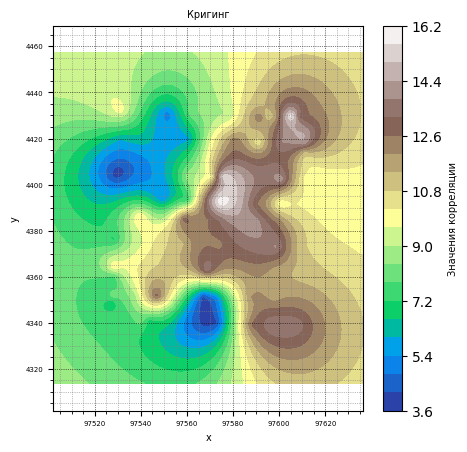

In [19]:
"""
Кросс-валидация для кригинга
"""
def cross_valid_for_UK(variogram_model, blocks_X, blocks_y, k):
    scores = [] # Инициализация списка для хранения оценок
    
    for i in range(k):
        # Создание обучающей и тестовой выборок
        X_train = np.concatenate([blocks_X[j] for j in range(k) if j != i])
        y_train = np.concatenate([blocks_y[j] for j in range(k) if j != i])
        X_test = blocks_X[i]
        y_test = blocks_y[i]
        # Обучение модели на обучающей выборке
        UK = UniversalKriging(X_train[:, 0], 
                              X_train[:, 1], 
                              y_train, 
                              variogram_model=variogram_model
                             )
        
        # Оценка модели на тестовой выборке
        y_pred, variance = UK.execute('points', 
                                         X_test[:, 0], 
                                         X_test[:, 1],
                                        )
        score = r2_score(y_test, y_pred)
        #if score < -1: score = -1
        scores.append(score)
    return scores

# Example
model = 'exponential'
k = 10 # Определение количества разбиений для кросс-валидации
num_corr = 1 # Столбец в матрице значений корр.
blocks_X = np.array_split(df_corr_train.loc[:, ["x", "y"]].to_numpy(), k)
blocks_y = np.array_split(df_corr_train.loc[:, num_corr].to_numpy(), k)
#blocks_y = np.array_split(np.mean(df_corr_train.loc[:, [1, 2, 3, 4, 5]].to_numpy(), axis=1), k)

scores = cross_valid_for_UK(model, blocks_X, blocks_y, k)        
print("Cross-validation score:", round(np.mean(scores), 2), np.max(scores), scores)

UK = UniversalKriging(np.concatenate(blocks_X[:-1])[:,0], 
                      np.concatenate(blocks_X[:-1])[:,1], 
                      np.concatenate(blocks_y[:-1]), 
                      variogram_model=model
                     )
x_new = np.linspace(np.min(np.concatenate(blocks_X[:-1])[:,0])-25, np.max(np.concatenate(blocks_X[:-1])[:,0])+25, 200)
y_new = np.linspace(np.min(np.concatenate(blocks_X[:-1])[:,1])-25, np.max(np.concatenate(blocks_X[:-1])[:,1])+25, 200)
z_new, variance = UK.execute('grid', x_new, y_new)
X, Y = np.meshgrid(x_new, y_new)

size_text = 7
plt.figure(figsize=(5, 5))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axis('equal')
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label('Значения корреляции', fontsize=size_text)
plt.title('Кригинг', fontsize=size_text)
plt.xlabel('x', fontsize=size_text)
plt.ylabel('y', fontsize=size_text)
plt.tick_params(labelsize=5)
plt.show()

In [20]:
"""
Подбор для MyCorr
"""
k = 10 # Определение количества разбиений для кросс-валидации
num_corr = 1 # Столбец в матрице значений корр.
blocks_X = np.array_split(df_corr_train.loc[:, ["x", "y"]].to_numpy(), k)
blocks_y = np.array_split(df_corr_train.loc[:, num_corr].to_numpy(), k)
#blocks_y = np.array_split(np.mean(df_corr_train.loc[:, [1, 2, 3, 4, 5]].to_numpy(), axis=1), k)

top_r2 = -1
top_params = "mean"

dim = 2  # Размерность пространства
var = 1  # Дисперсия
nugget = 1
w = 1
Df = 0.5
Dl = 0.5
anis = 1
angles = 0

for len_scale in [1, 5, 10]:  # Масштаб корреляции
    for Dl in [0.5, 1]:
        for nugget in [0, 1, 10]:
    #for anis in [i/10 for i in [1, 2, 5, 10]]:  # Коэффициент анизотропии
        #for angles in [i*10 for i in range(18)]:  # Угол поворота
            model= MyCovModel(dim=dim, 
                              var=var, 
                              len_scale=len_scale, 
                              nugget=nugget, 
                              anis=anis, 
                              angles=angles, 
                              w=w, 
                              Df=Df, 
                              Dl=Dl
                             )
            
            scores = cross_valid_for_UK(model, blocks_X, blocks_y, k)
            
            print("Cross-validation score:", round(np.mean(scores), 2), len_scale, Dl, nugget)
            
            r2_now = np.mean(scores)
            
            if top_r2 < r2_now:
                top_r2 = r2_now
                top_params = [len_scale, nugget, Dl, w]

print(top_r2, top_params)

Cross-validation score: -0.28 1 0.5 0
Cross-validation score: -0.28 1 0.5 1
Cross-validation score: -0.28 1 0.5 10
Cross-validation score: -0.27 1 1 0
Cross-validation score: -0.27 1 1 1
Cross-validation score: -0.27 1 1 10
Cross-validation score: 0.36 5 0.5 0
Cross-validation score: 0.36 5 0.5 1
Cross-validation score: 0.36 5 0.5 10
Cross-validation score: 0.35 5 1 0
Cross-validation score: 0.35 5 1 1
Cross-validation score: 0.35 5 1 10
Cross-validation score: 0.28 10 0.5 0
Cross-validation score: 0.28 10 0.5 1
Cross-validation score: 0.28 10 0.5 10
Cross-validation score: 0.33 10 1 0
Cross-validation score: 0.33 10 1 1
Cross-validation score: 0.33 10 1 10
0.3583251181368629 [5, 1, 0.5, 1]


0.4137296230128824


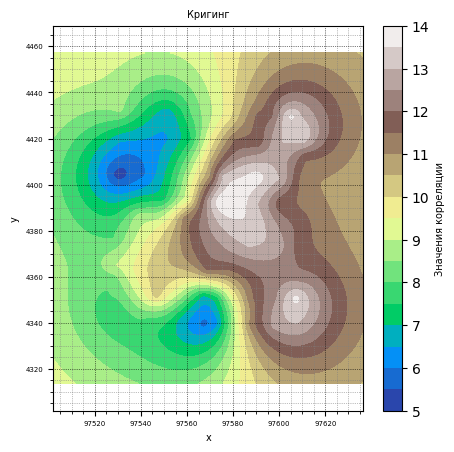

In [21]:
len_scale, nugget, Dl, w = top_params
#anis, angles = .5, 120
model= MyCovModel(dim=dim, 
                  var=var, 
                  len_scale=len_scale, 
                  nugget=nugget, 
                  anis=anis, 
                  angles=angles, 
                  w=w, 
                  Df=Df, 
                  Dl=Dl
                 )
#model = 'exponential'

num_corr = 1 # Столбец в матрице значений корр.
UK = UniversalKriging(df_corr_train.loc[:, "x"].to_numpy(), 
                      df_corr_train.loc[:, "y"].to_numpy(), 
                      df_corr_train.loc[:, num_corr].to_numpy(), 
                      variogram_model=model
                     )
x_new = np.linspace(np.min(df_corr_train.loc[:, "x"].to_numpy())-25, np.max(df_corr_train.loc[:, "x"].to_numpy())+25, 200)
y_new = np.linspace(np.min(df_corr_train.loc[:, "y"].to_numpy())-25, np.max(df_corr_train.loc[:, "y"].to_numpy())+25, 200)
z_new, variance = UK.execute('grid', x_new, y_new)
X, Y = np.meshgrid(x_new, y_new)

z_predict, variance = UK.execute('points', df_corr_test["x"].to_numpy(), df_corr_test["y"].to_numpy())
print(r2_score(df_corr_test[num_corr], z_predict))


size_text = 7
plt.figure(figsize=(5, 5))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axis('equal')
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label('Значения корреляции', fontsize=size_text)
plt.title('Кригинг', fontsize=size_text)
plt.xlabel('x', fontsize=size_text)
plt.ylabel('y', fontsize=size_text)
plt.tick_params(labelsize=5)
plt.show()